In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from datetime import datetime, timedelta

In [2]:
datapath = '../data/'

In [3]:
import glob
files = glob.glob(datapath+'*.csv')
files[0]

'../data/FC3DC207-9459-4CBE-8AB5-0E0AC77D5FEC.csv'

In [4]:
dfs = [pd.read_csv(f) for f in files]
dfs[1] = dfs[1].rename(columns={" timestamp ": "timestamp"})

In [5]:
for df in dfs:
    df['mag'] = np.sqrt(df['x']**2+df['y']**2+df['z']**2)
    df['time'] = pd.to_datetime(df['timestamp'], unit='ms')
dfs[0].head(5)

timestamp           type        lat        lon      height  accuracy  \
0  1.431035e+12            gps  41.978753 -87.893018  194.760063      10.0   
1  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   
2  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   
3  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   
4  1.431035e+12  accelerometer        NaN        NaN         NaN       NaN   

   speed     bearing         x         y         z       mag  \
0  14.36  139.570312       NaN       NaN       NaN       NaN   
1    NaN         NaN -0.075974 -0.448395 -0.867188  0.979206   
2    NaN         NaN -0.079025 -0.435837 -0.919876  1.020966   
3    NaN         NaN -0.069183 -0.456039 -0.921722  1.030694   
4    NaN         NaN -0.059341 -0.456772 -0.896149  1.007593   

                        time  
0 2015-05-07 21:46:58.761430  
1 2015-05-07 21:46:58.834430  
2 2015-05-07 21:46:58.932430  
3 2015-05-07 21:46:59.030430  
4 2015-05-07 21:46:59.129430

In [29]:
def prepare_dfs(dfs,window):
    sorted_dfs = []
    rolling_mean = []
    rolling_std = []
    for df in dfs:
        _temp = df.sort_values(by='time')
        _temp = _temp.set_index(['time'])

        _mean = _temp.rolling(window).mean()
        _std = _temp.rolling(window).std()
    
        sorted_dfs.append(_temp)
        rolling_mean.append(_mean)
        rolling_std.append(_std)
    
    return sorted_dfs, rolling_mean, rolling_std


In [34]:
sorted_dfs, rolling_mean, rolling_std = prepare_dfs(dfs,'1s')

In [35]:
def Find_events(dfs, variable, window):
    events_df = pd.DataFrame()
    drivers = []
    for i in range(6,24):
        test = dfs[i].sort_values(by='time')
        test = test.set_index(['time'])

        test2 = test.rolling(window).mean()
        test2_std = test.rolling(window).std()

        orig_df = dfs[i][['time',variable]]
        orig_df = orig_df.set_index(['time'])
        orig_df_plot = orig_df.dropna(axis=0,how='any')


        for j in range(0,len(test.index)):
            if test[variable][j] > (test2[variable][j]+(2.9*test2_std[variable][j])):
                #print(i,test2.index[j])
                events_df = events_df.append(test.iloc[j])
                drivers.append(i)
    events_df['driver']=drivers
    return events_df
                

In [36]:
event = Find_events(dfs,'mag','1s')

In [40]:
event.head(3)

accuracy  bearing  height  lat  lon       mag  \
2015-03-19 20:50:03.761870       NaN      NaN     NaN  NaN  NaN  1.076214   
2015-03-19 20:53:07.782870       NaN      NaN     NaN  NaN  NaN  1.591640   
2015-03-19 20:53:11.084870       NaN      NaN     NaN  NaN  NaN  1.748581   

                            speed     timestamp           type         x  \
2015-03-19 20:50:03.761870    NaN  1.426798e+12  accelerometer -0.751694   
2015-03-19 20:53:07.782870    NaN  1.426798e+12  accelerometer  0.338928   
2015-03-19 20:53:11.084870    NaN  1.426798e+12  accelerometer -0.224045   

                                   y         z  driver  
2015-03-19 20:50:03.761870  0.765961 -0.080612       6  
2015-03-19 20:53:07.782870 -0.938950 -1.239685       6  
2015-03-19 20:53:11.084870 -0.291351 -1.709518       6

In [39]:
event.iloc[0]

accuracy               NaN
bearing                NaN
height                 NaN
lat                    NaN
lon                    NaN
mag                1.07621
speed                  NaN
timestamp       1.4268e+12
type         accelerometer
x                -0.751694
y                 0.765961
z               -0.0806122
driver                   6
Name: 2015-03-19 20:50:03.761870, dtype: object

In [113]:
def Plot_crash(event, raw_profile, rolling_mean):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
    
    ax1.plot(raw_profile.index,raw_profile.mag)
    ax1.plot(rolling_mean.index, rolling_mean.mag)
    ax1.plot(event.index,event.mag, marker='*',markersize=20,c='k')
 
    ax2.plot(raw_profile.index,raw_profile.mag)
    ax2.plot(rolling_mean.index, rolling_mean.mag)
    ax2.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax2.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
             
    speed_df = raw_profile[['speed','lat','lon','height']].dropna(axis=0)
    ax3.plot(speed_df.index,speed_df.speed)
    ax3.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    
    ax4.plot(speed_df.index,speed_df.speed)
    ax4.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax4.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    
    
    
    plt.show()

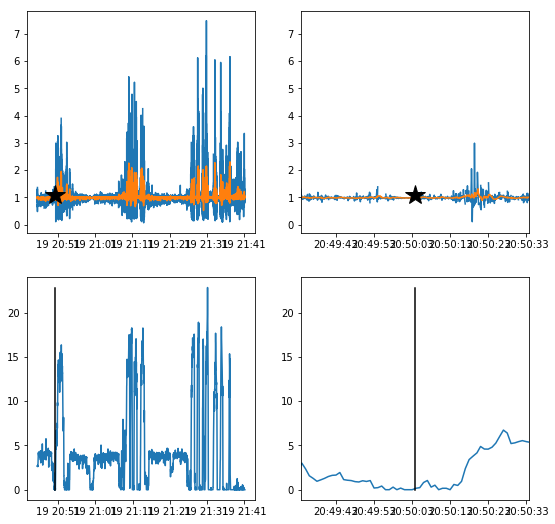

In [114]:
Plot_crash(event.iloc[0:1],sorted_dfs[6], rolling_mean[6])

In [116]:
event.head(5)

accuracy  bearing  height  lat  lon       mag  \
2015-03-19 20:50:03.761870       NaN      NaN     NaN  NaN  NaN  1.076214   
2015-03-19 20:53:07.782870       NaN      NaN     NaN  NaN  NaN  1.591640   
2015-03-19 20:53:11.084870       NaN      NaN     NaN  NaN  NaN  1.748581   
2015-03-19 20:53:13.320870       NaN      NaN     NaN  NaN  NaN  2.165949   
2015-03-19 21:07:17.232870       NaN      NaN     NaN  NaN  NaN  1.596844   

                            speed     timestamp           type         x  \
2015-03-19 20:50:03.761870    NaN  1.426798e+12  accelerometer -0.751694   
2015-03-19 20:53:07.782870    NaN  1.426798e+12  accelerometer  0.338928   
2015-03-19 20:53:11.084870    NaN  1.426798e+12  accelerometer -0.224045   
2015-03-19 20:53:13.320870    NaN  1.426798e+12  accelerometer  0.226974   
2015-03-19 21:07:17.232870    NaN  1.426799e+12  accelerometer -0.665009   

                                   y         z  driver  
2015-03-19 20:50:03.761870  0.765961 -0.080612       6  
2015-03-19 20:53:07.782870 -0.938950 -1.239685       6  
2015-03-19 20:53:11.084870 -0.291351 -1.709518       6  
2015-03-19 20:53:13.320870 -2.078445 -0.565582       6  
2015-03-19 21:07:17.232870 -0.065903  1.450287       6

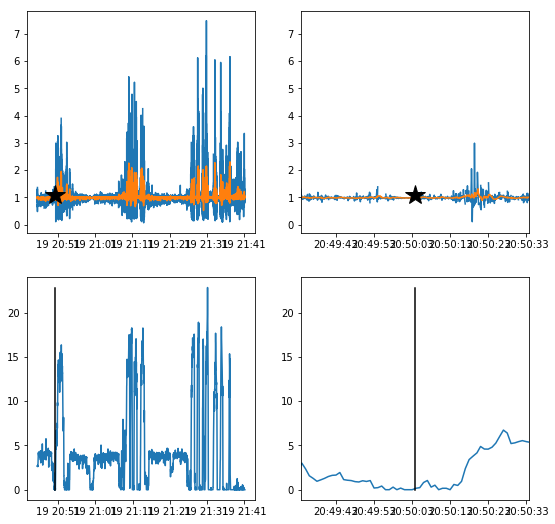

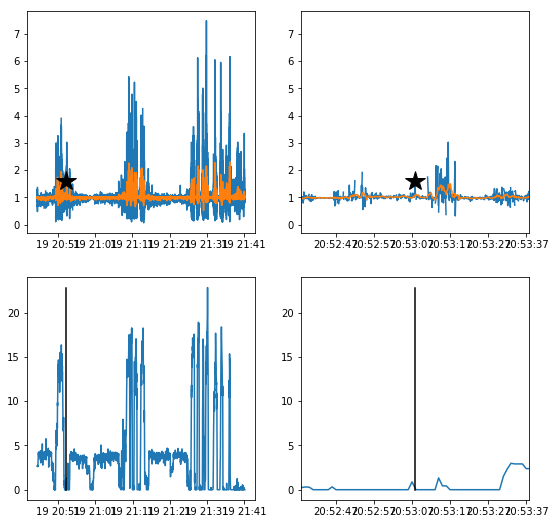

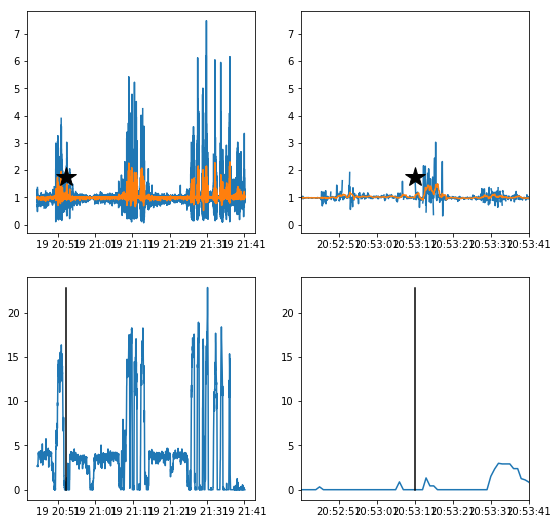

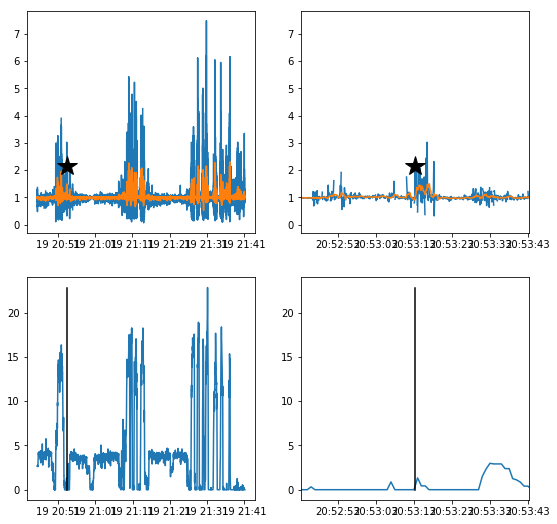

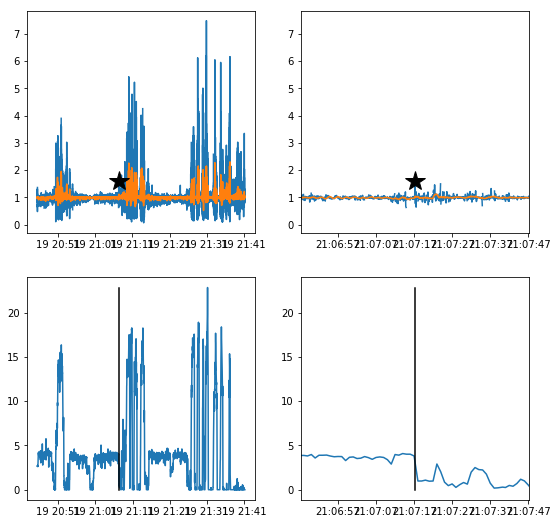

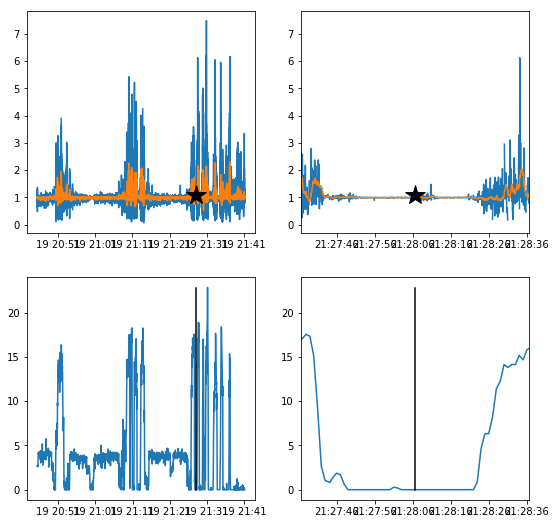

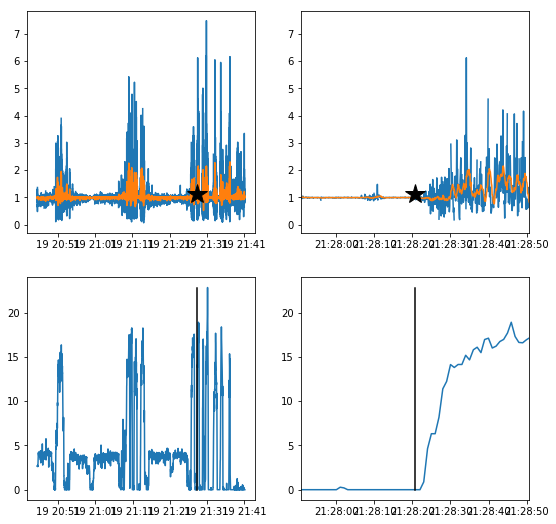

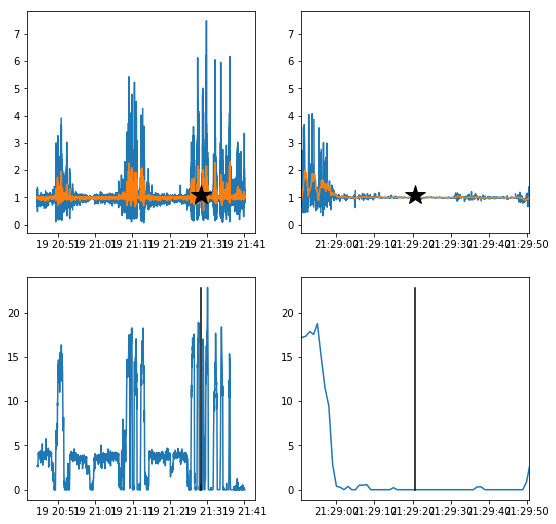

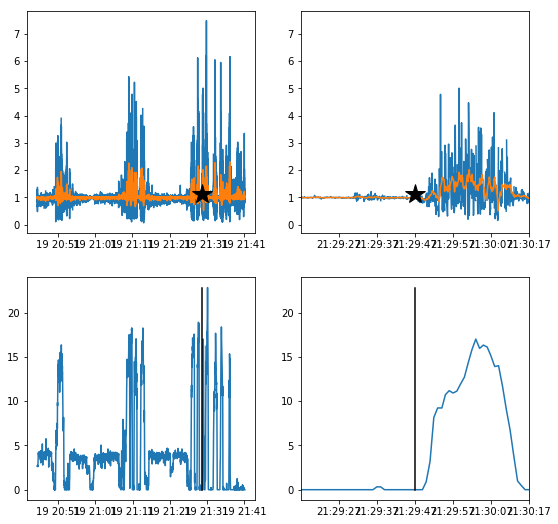

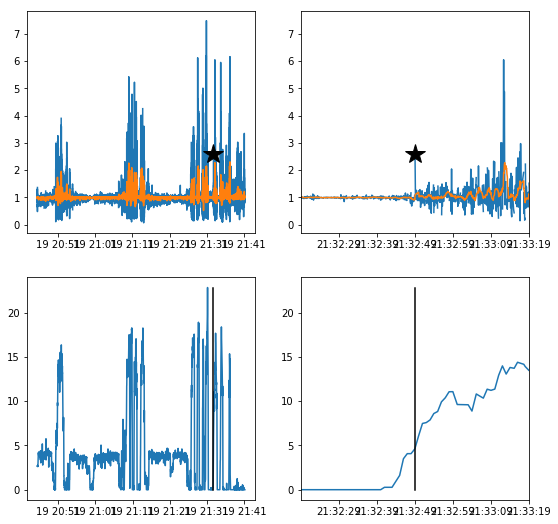

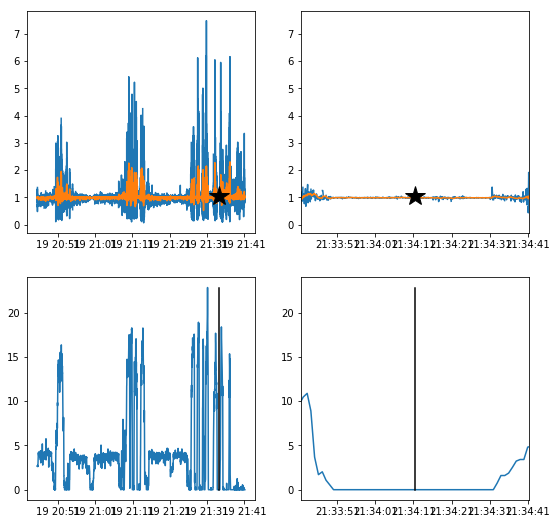

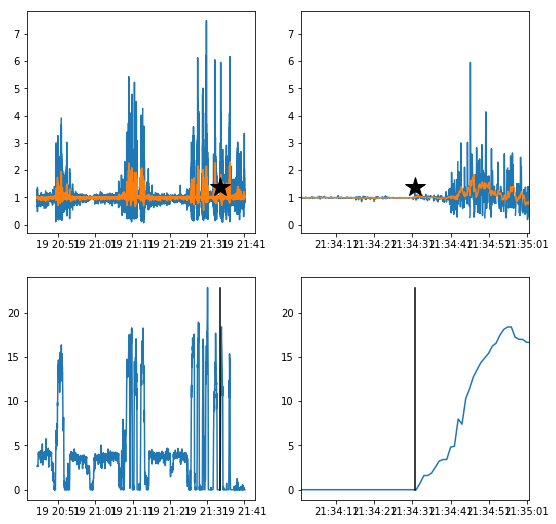

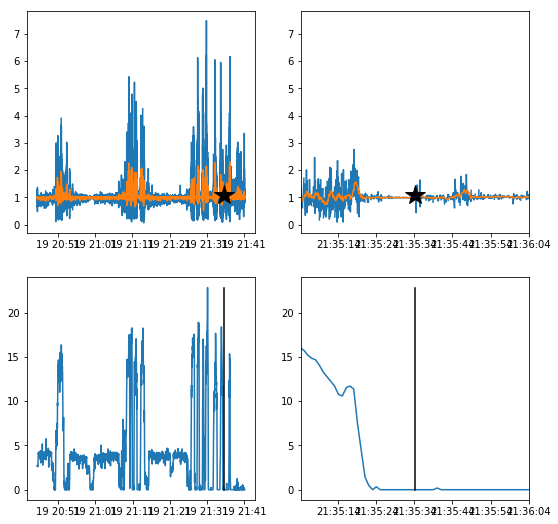

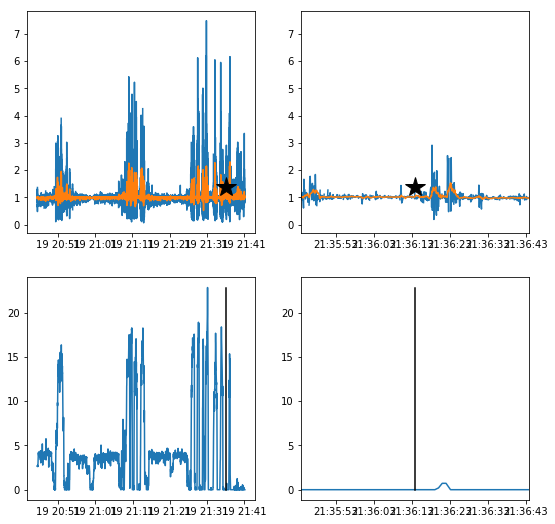

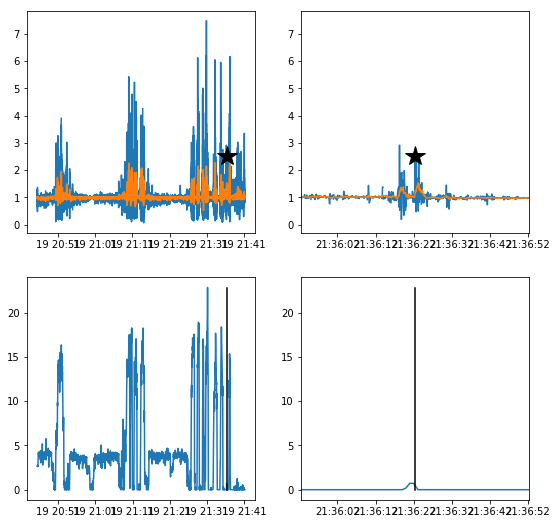

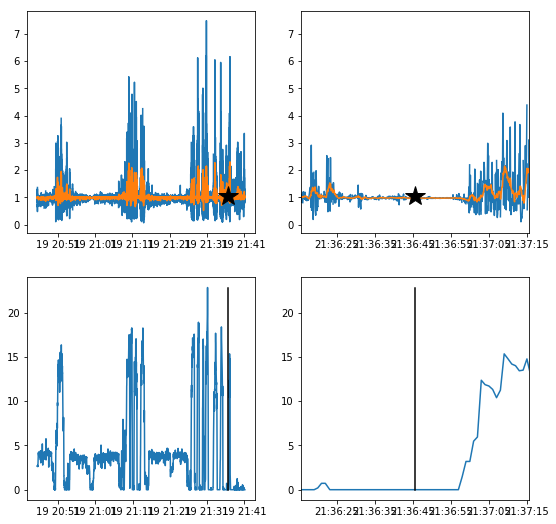

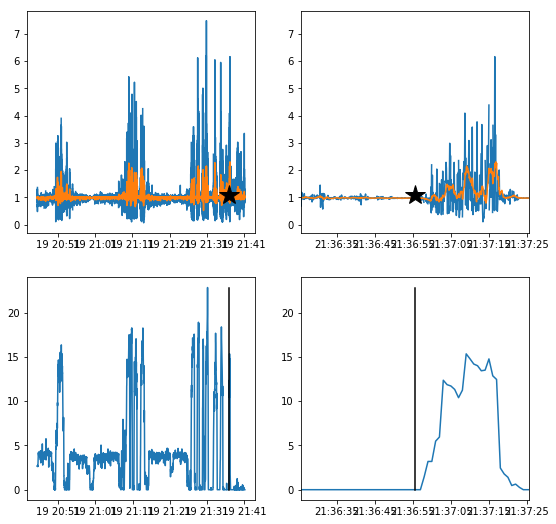

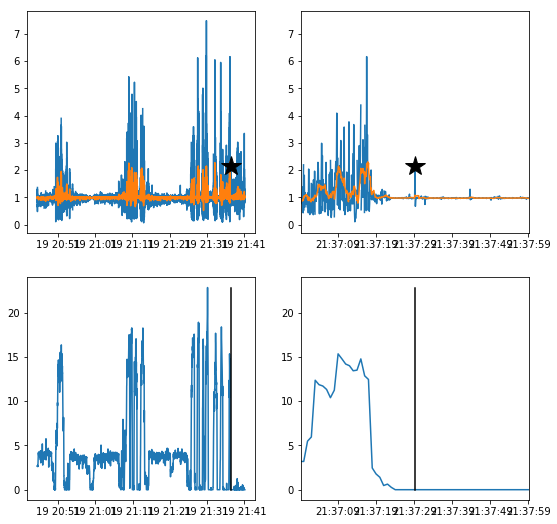

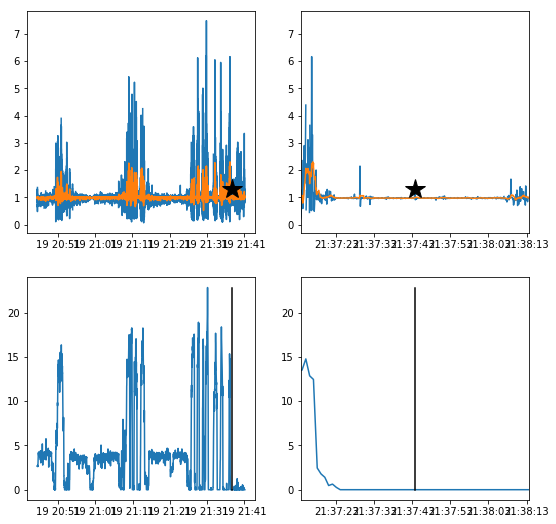

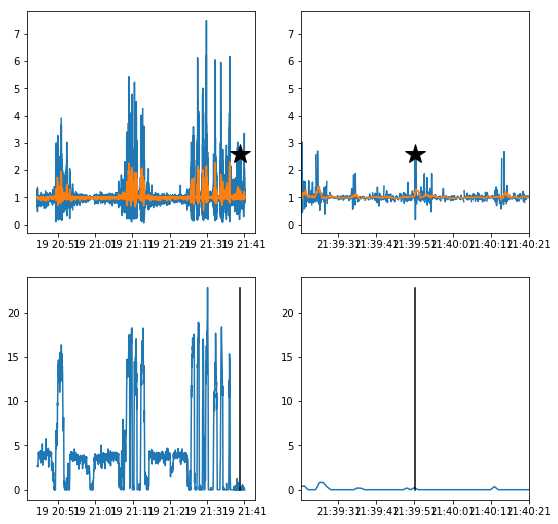

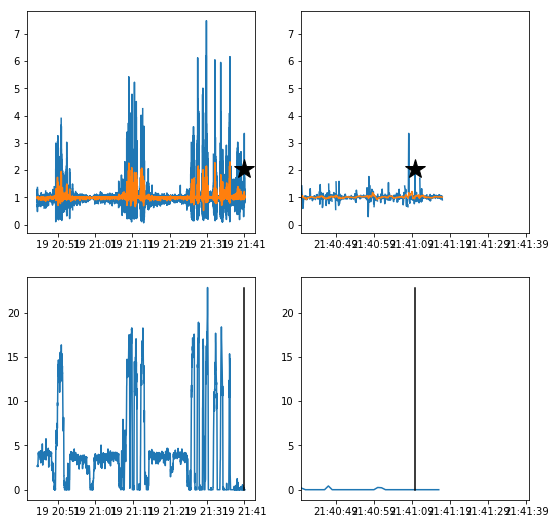

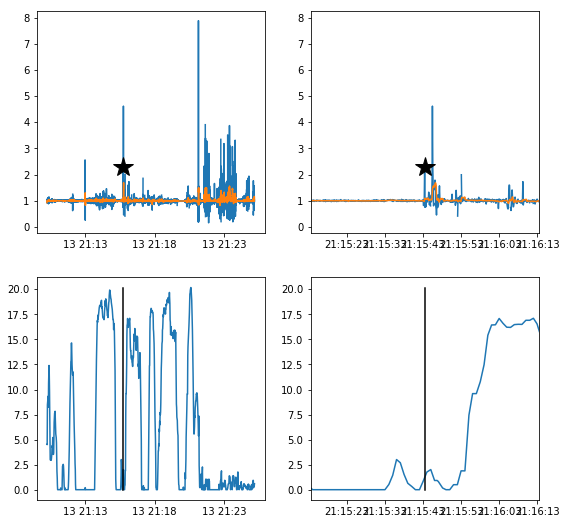

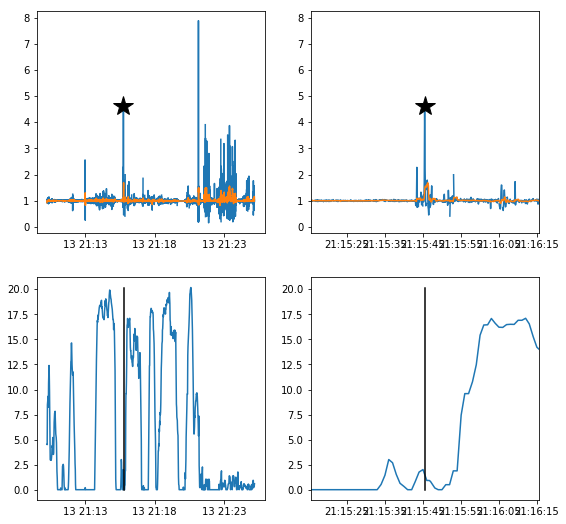

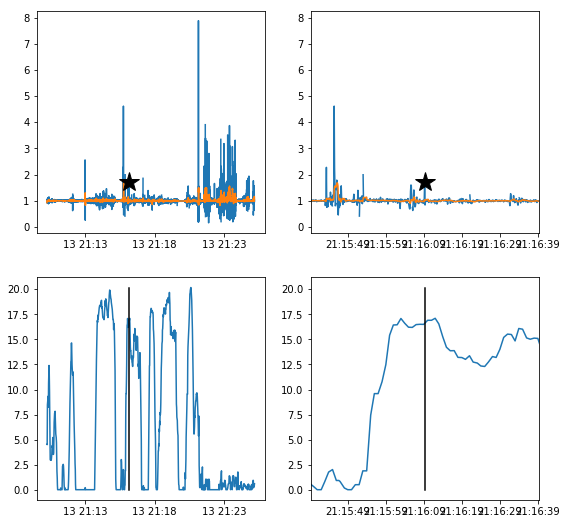

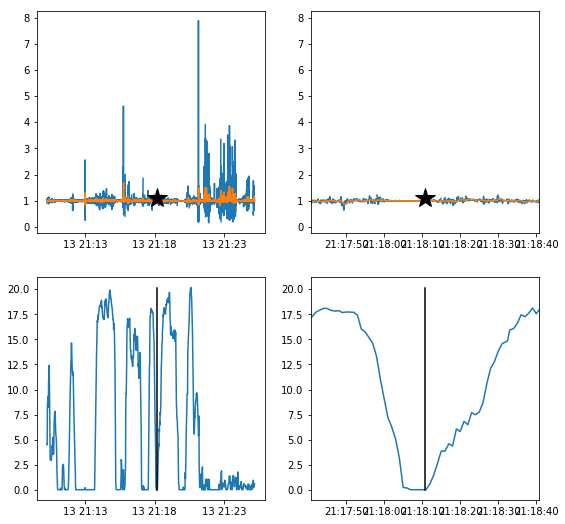

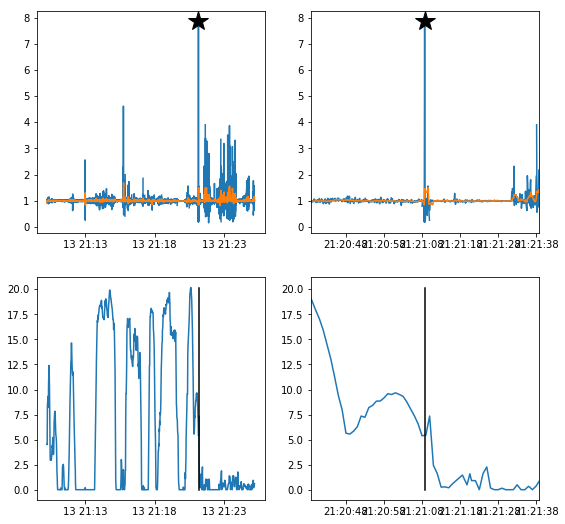

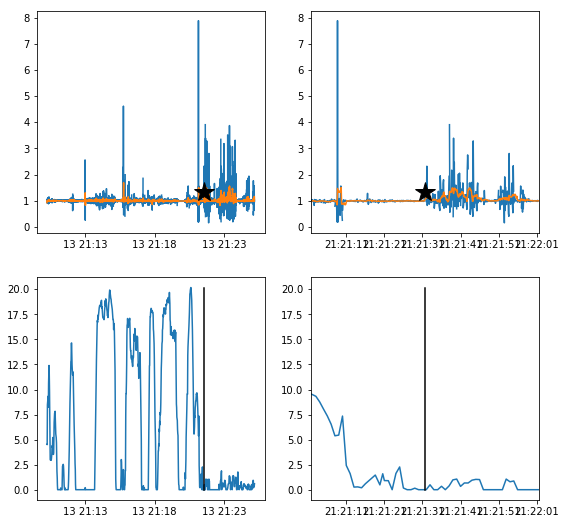

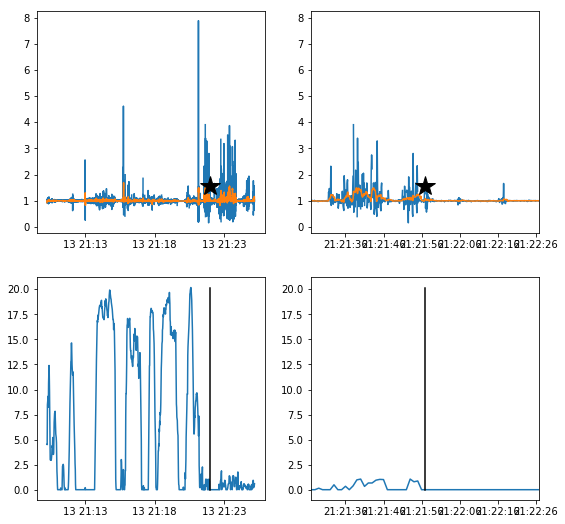

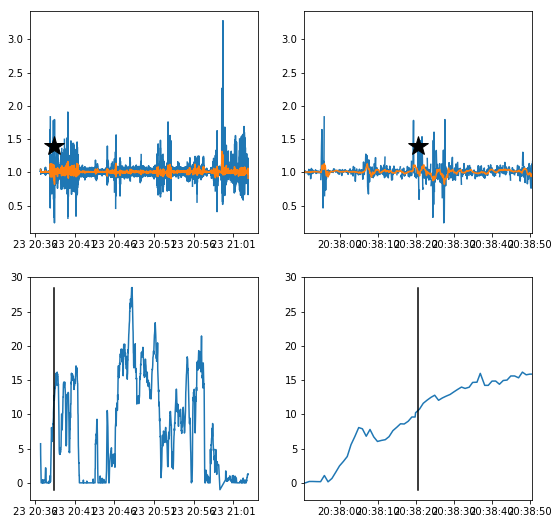

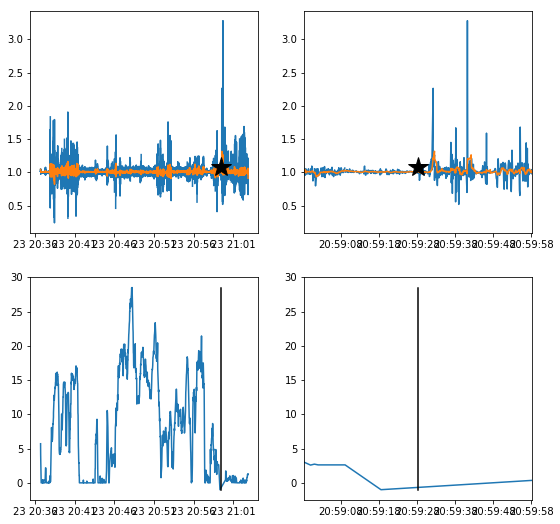

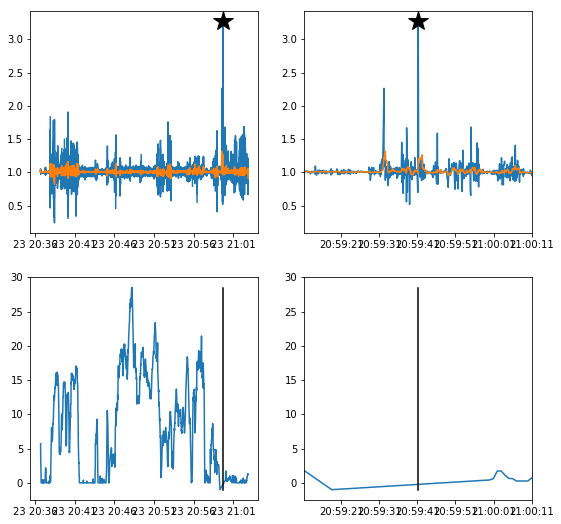

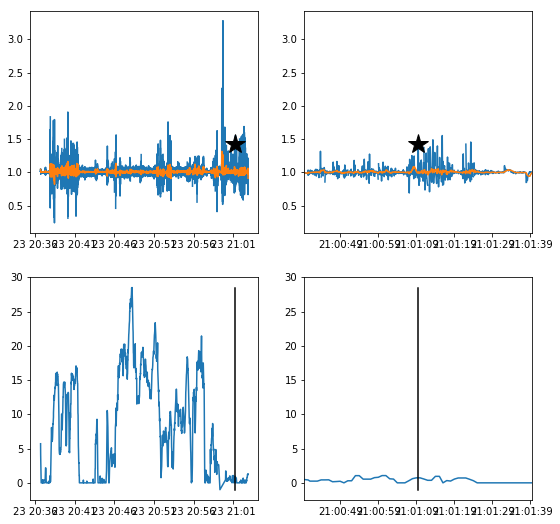

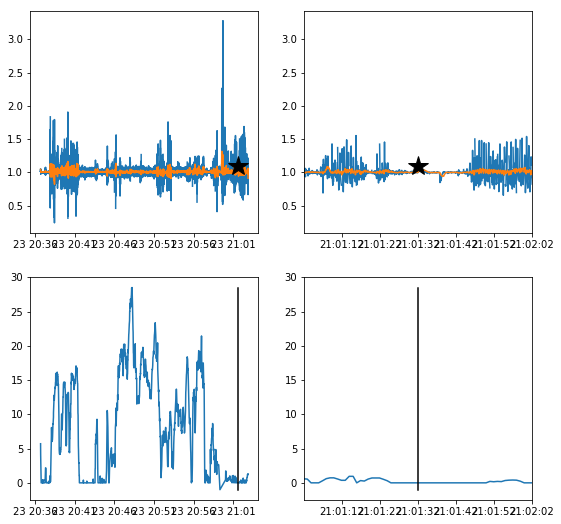

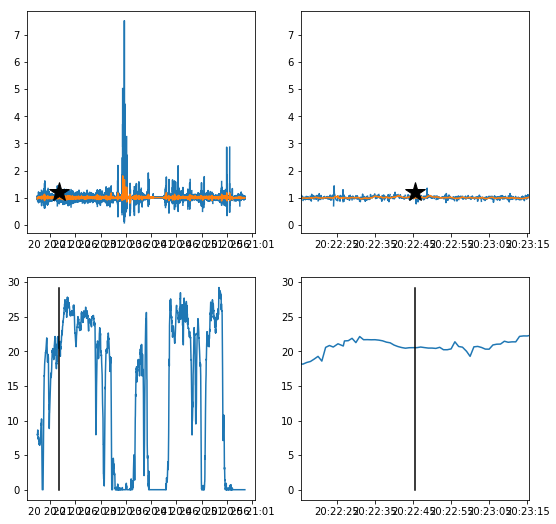

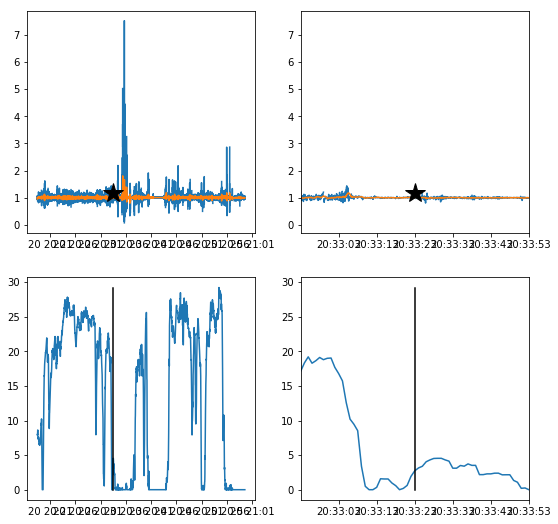

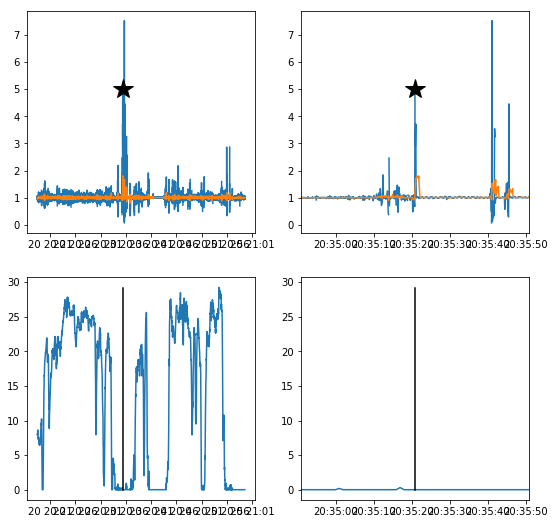

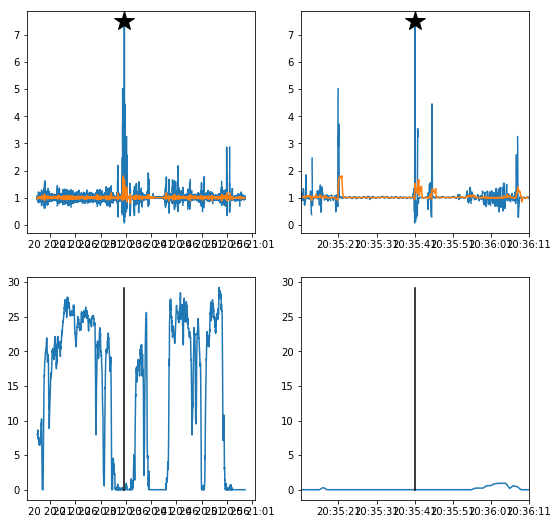

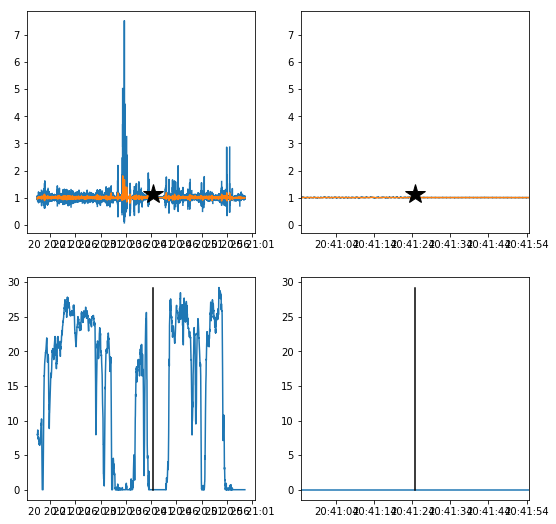

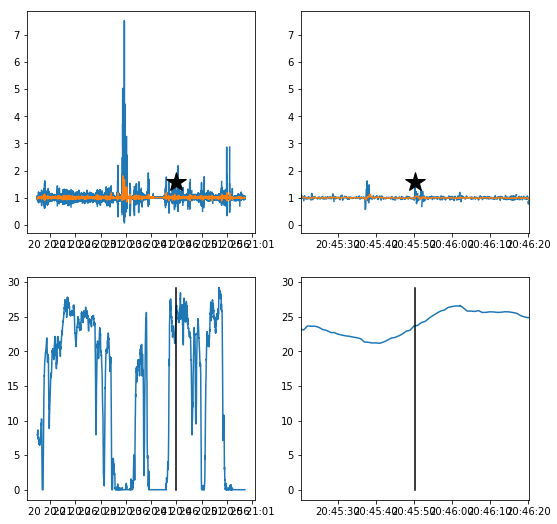

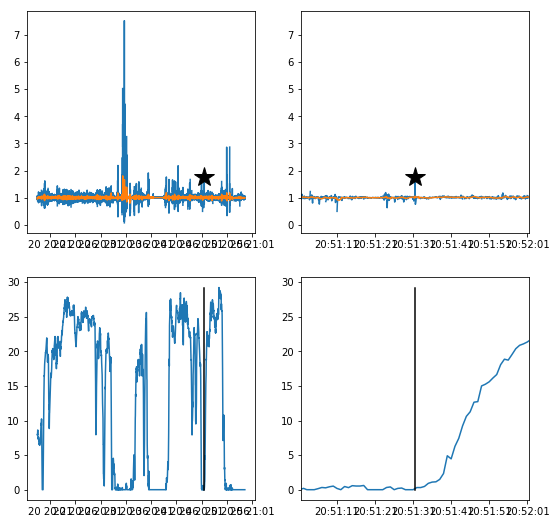

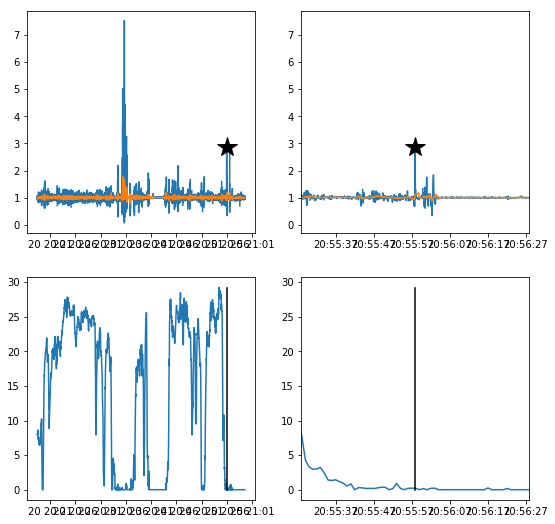

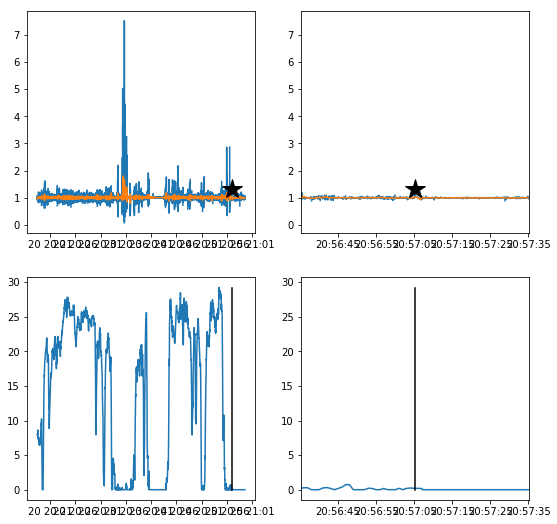

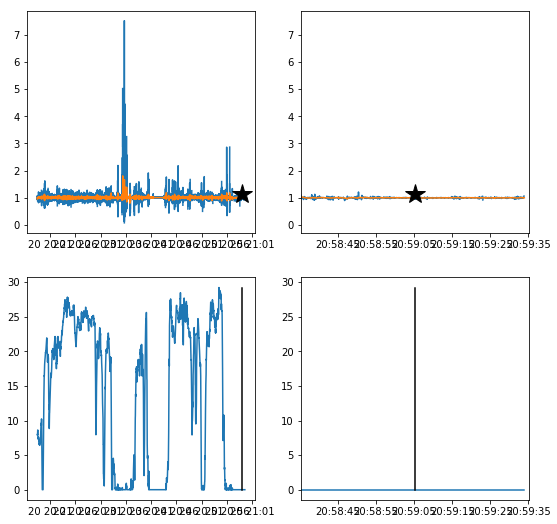

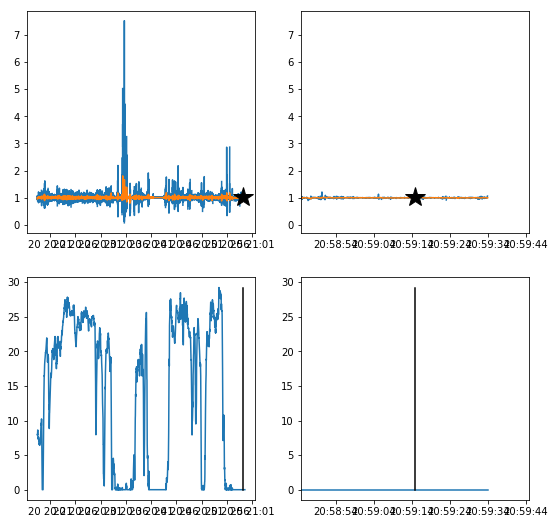

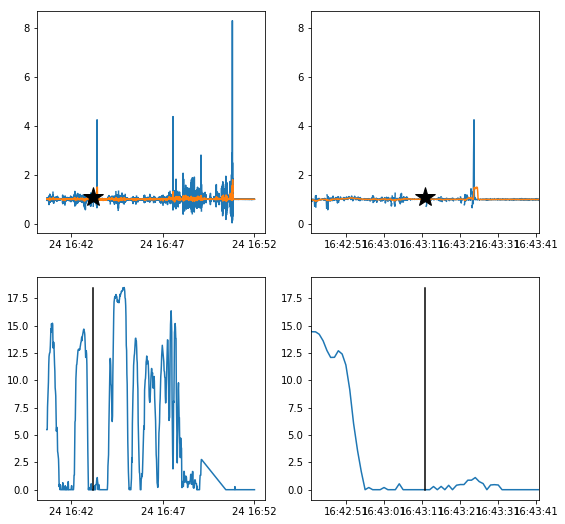

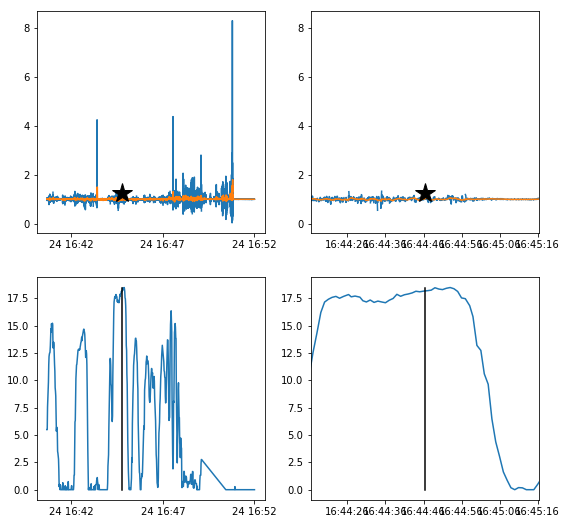

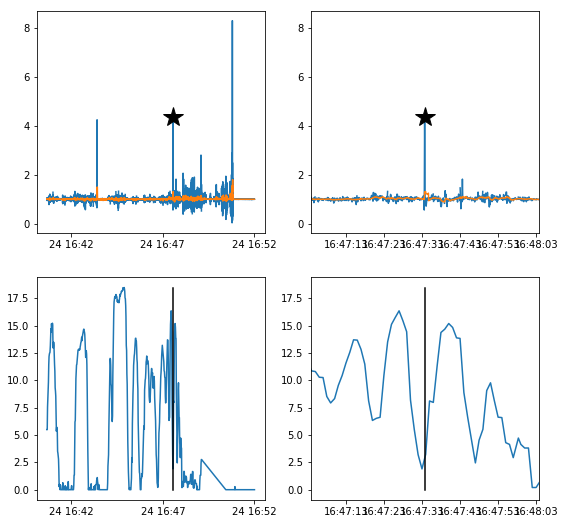

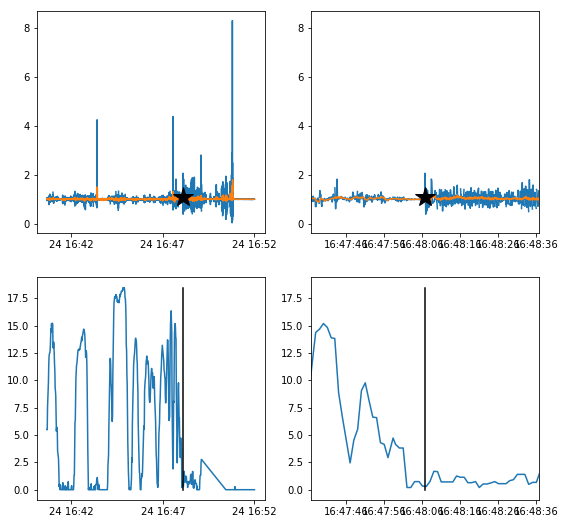

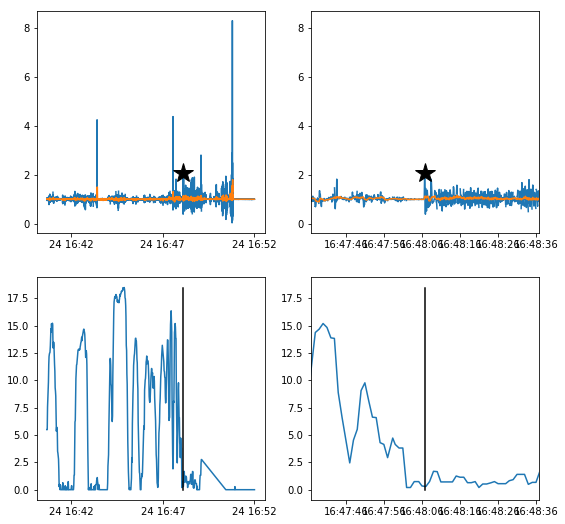

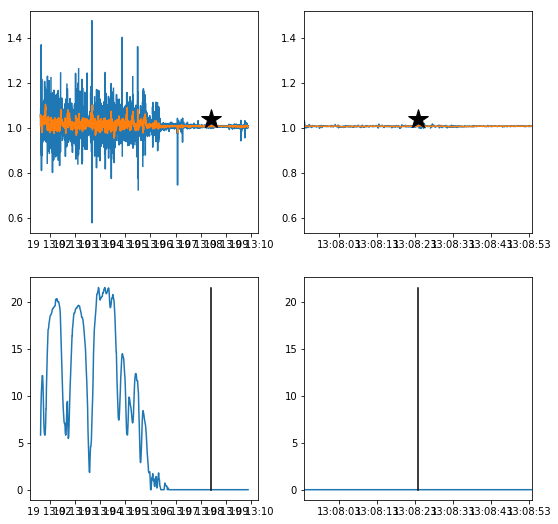

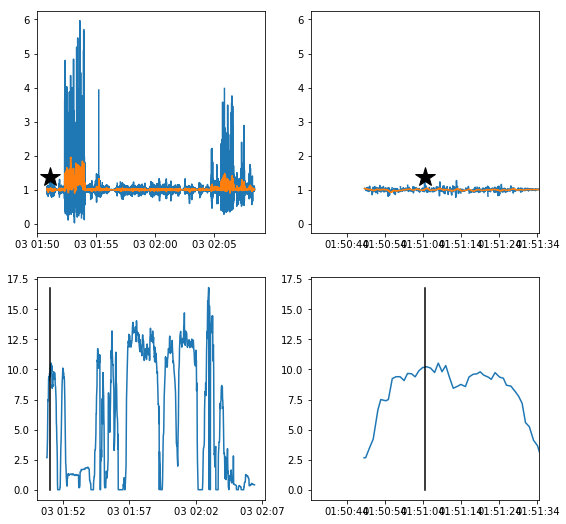

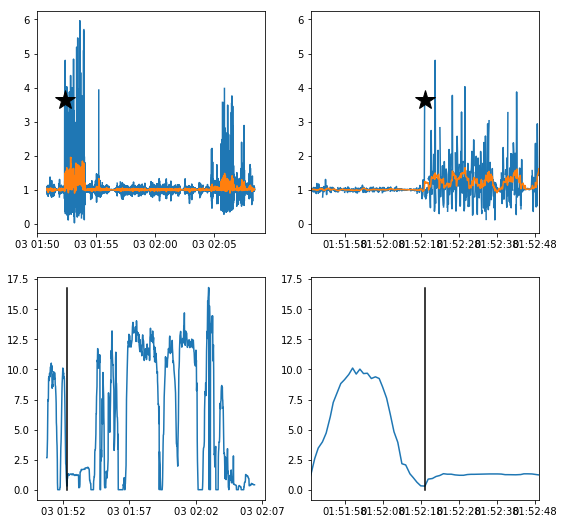

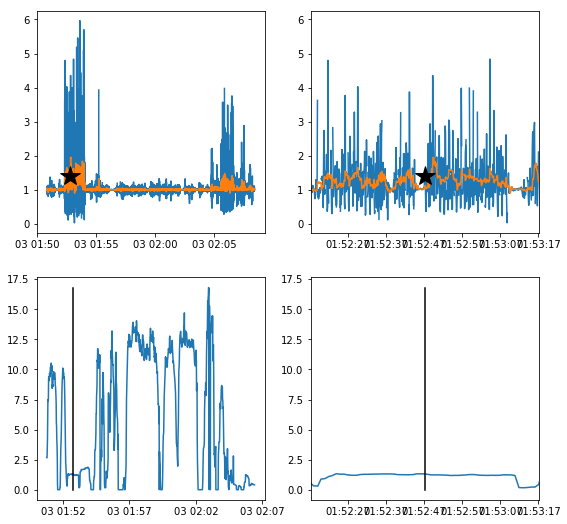

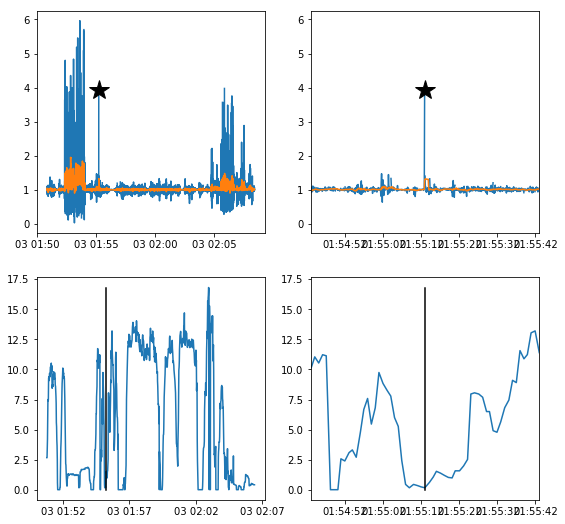

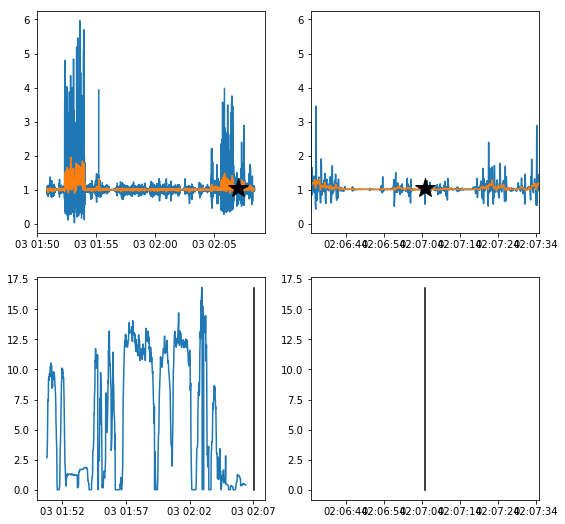

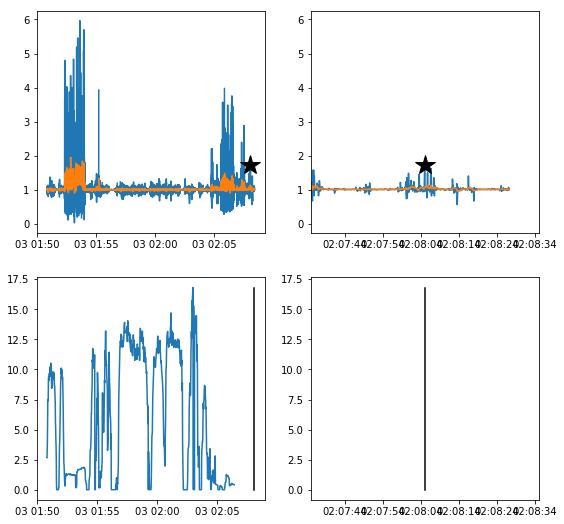

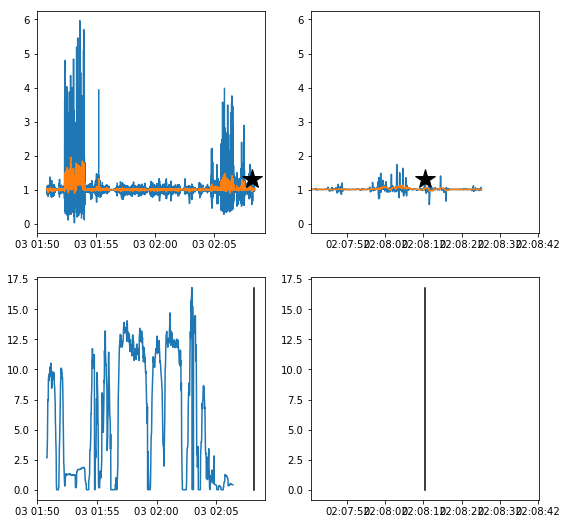

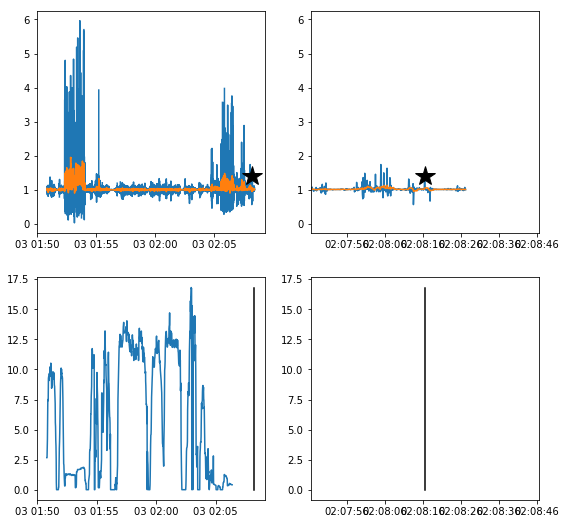

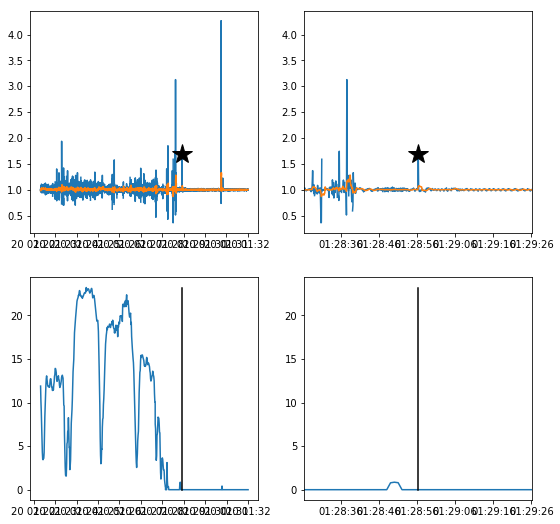

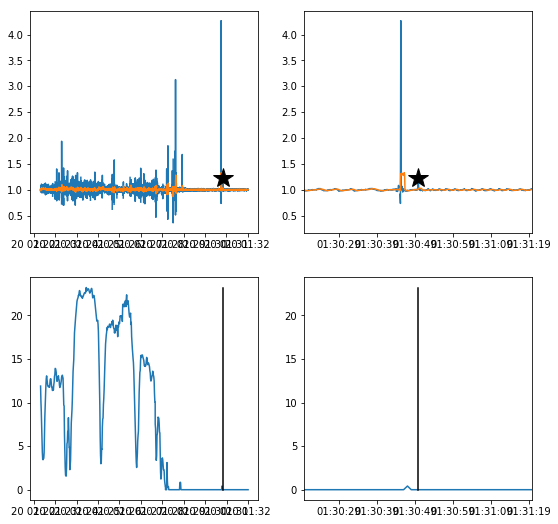

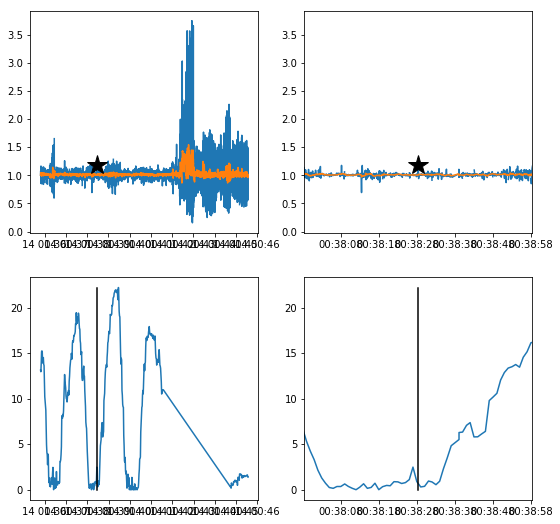

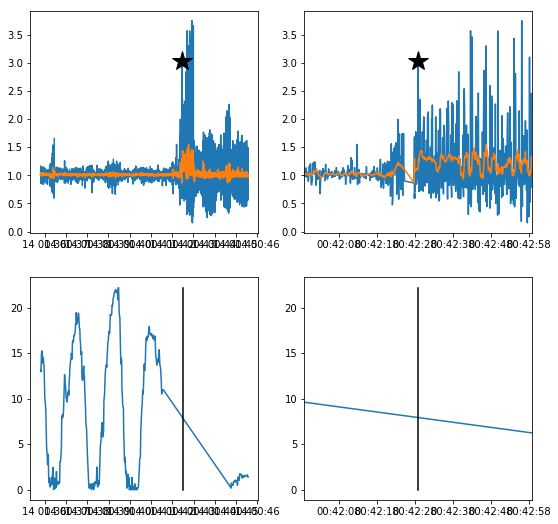

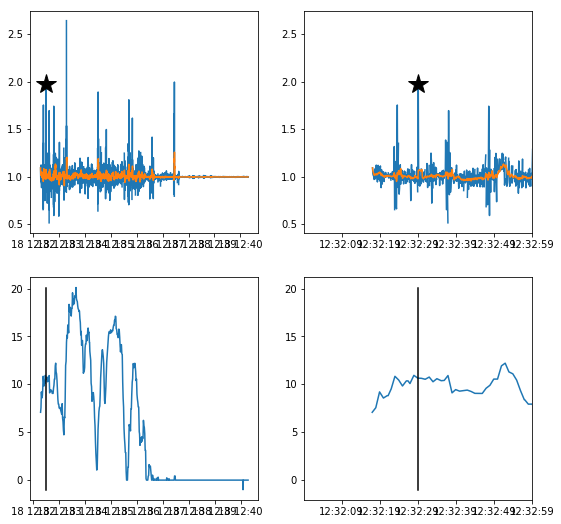

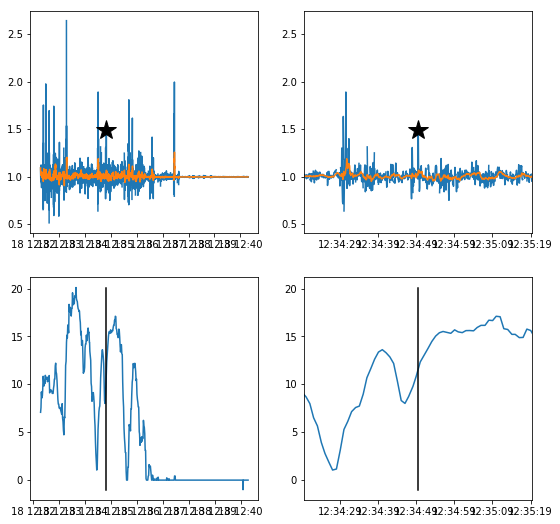

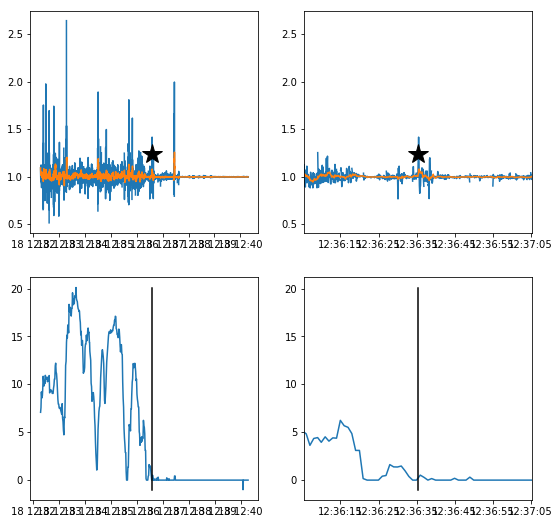

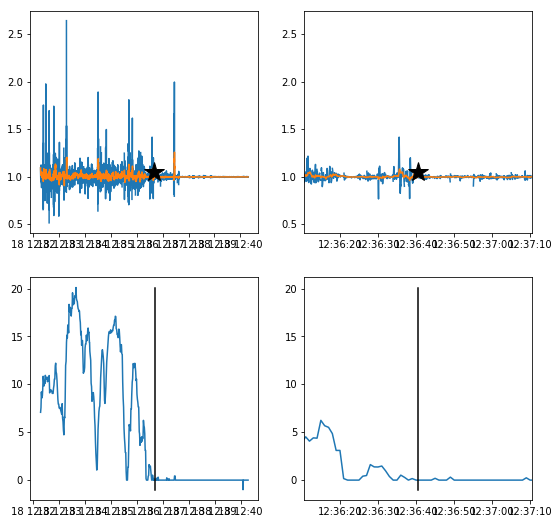

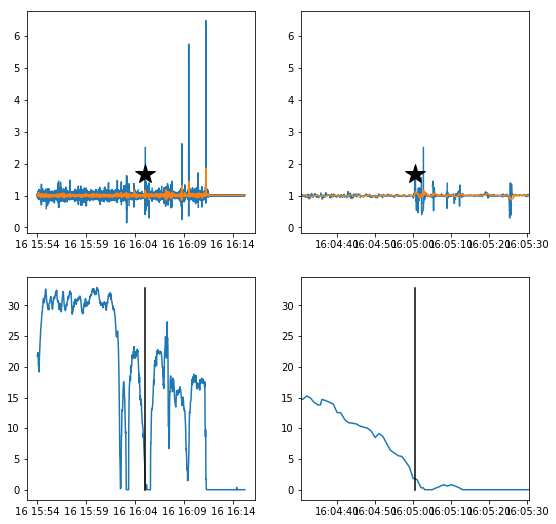

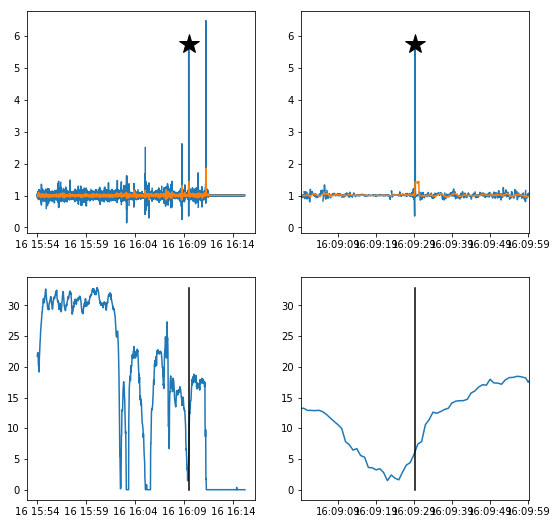

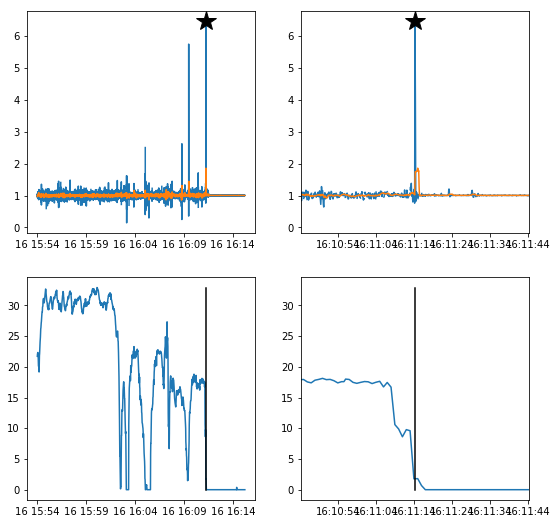

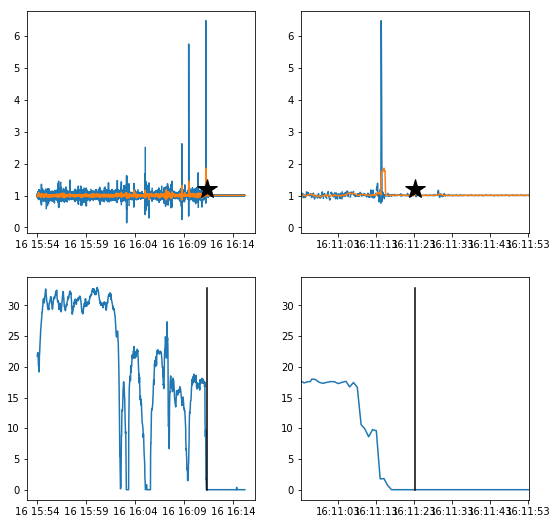

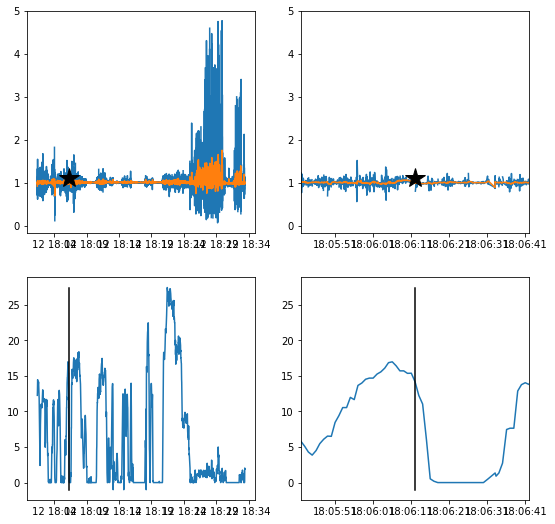

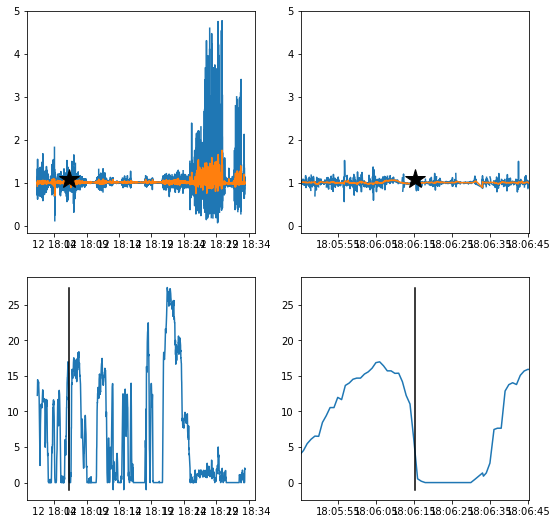

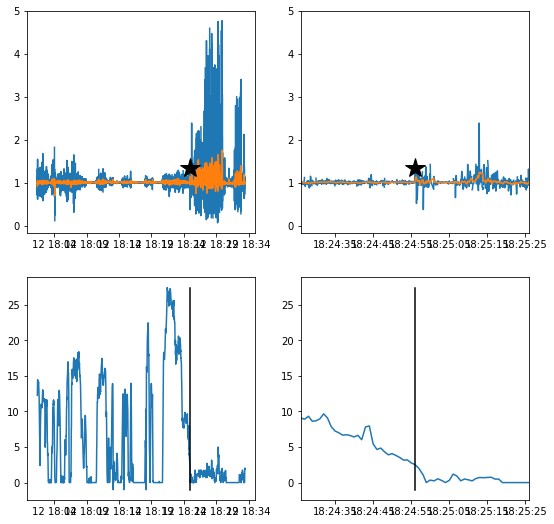

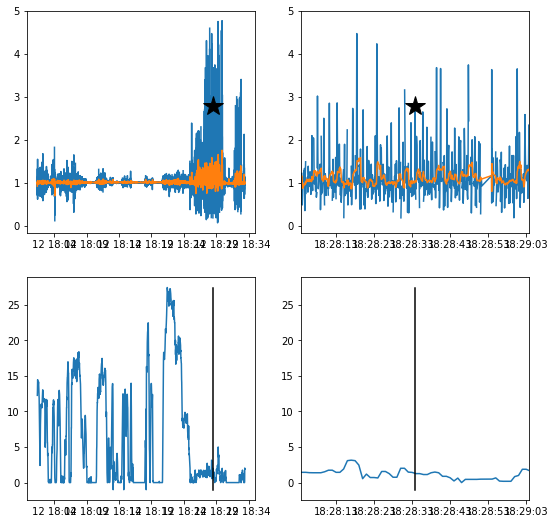

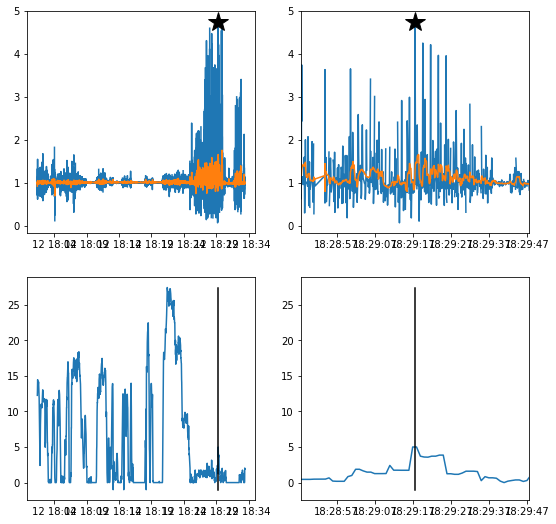

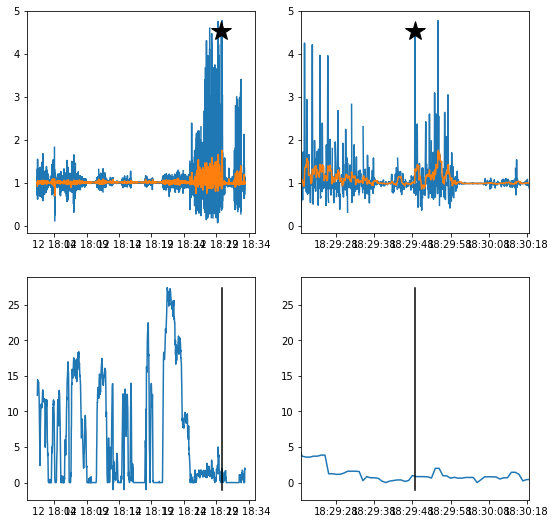

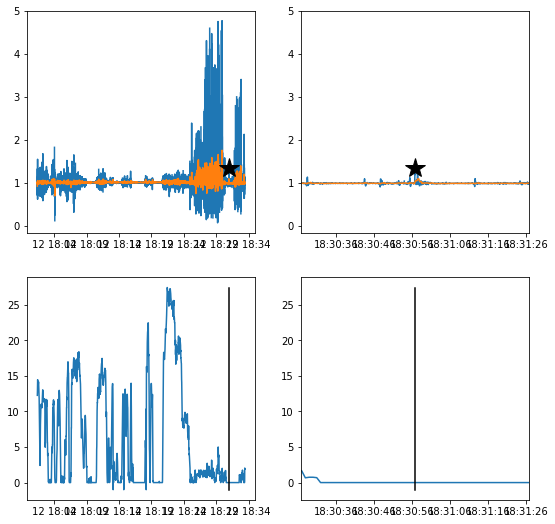

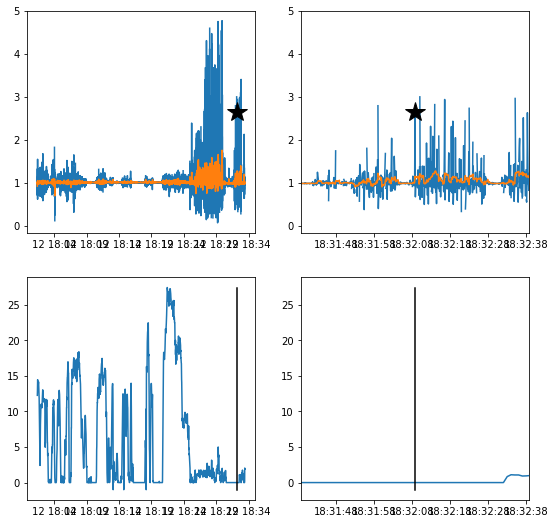

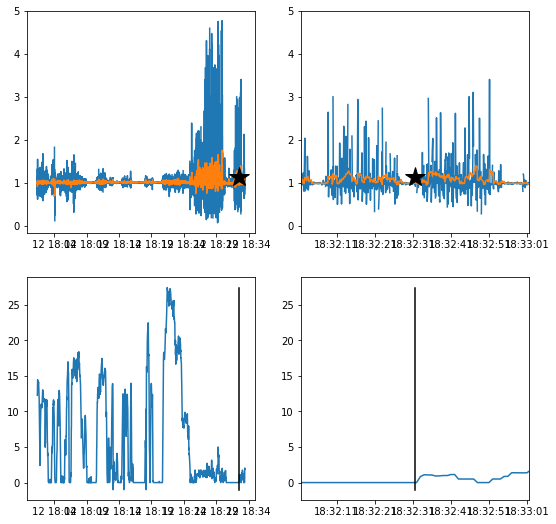

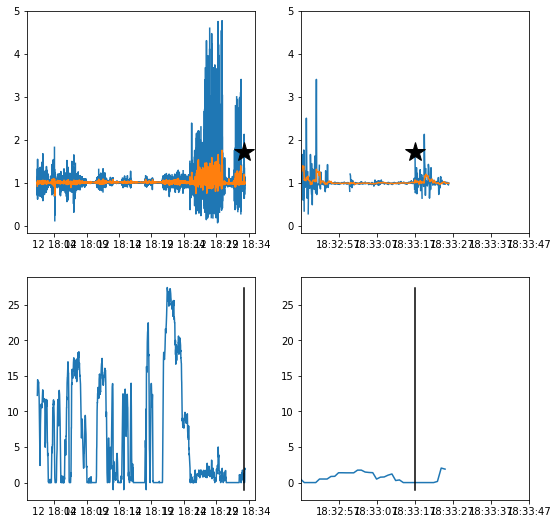

In [120]:
for i in range(0,len(event.index)):
    #print(event.driver[i])
    Plot_crash(event.iloc[i:i+1],sorted_dfs[event.driver[i]], rolling_mean[event.driver[i]])
    